<a href="https://colab.research.google.com/github/superchromat/CE888/blob/master/bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier
%matplotlib inline

* We have loaded the necessary libraries above
# Now let's load the data

In [2]:
df = df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv", delimiter = ";")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [3]:
# look at the counts of the values under 'default' column
df['default'].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [4]:
# look at the data types of the columns in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

No missing values

In [5]:
# look at the counts of the values under 'job' column
df['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [6]:
# look at the counts of the values under 'marital' column
df['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

Now let's do some checks of the numerical columns.

In [7]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


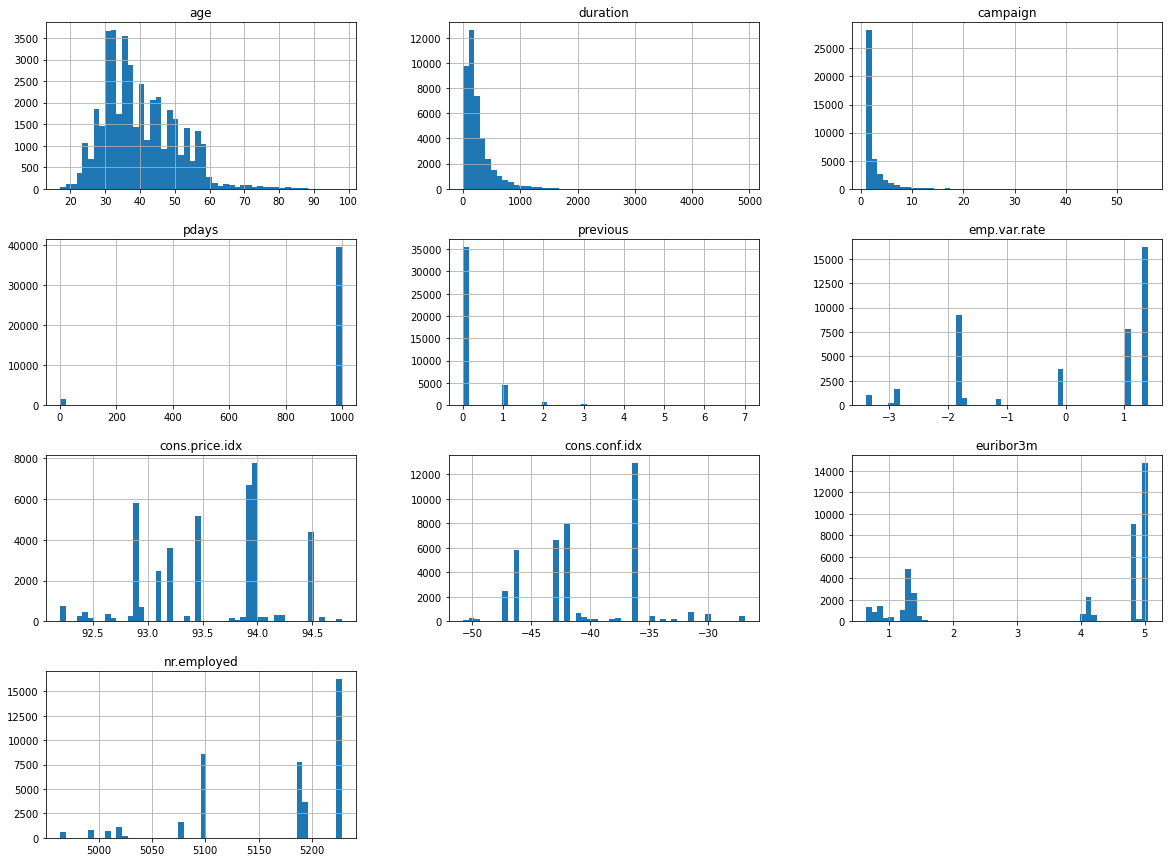

In [8]:
# create a histogram of the numerical columns
_ = df.hist(bins=50, figsize=(20,15))

In [9]:
# column names to extract the features
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [10]:
features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
           'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
           'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
           'cons.conf.idx', 'euribor3m', 'nr.employed']
label = ['y']
df[features]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6


In [11]:
# Scatterplots
#_ = sns.pairplot(df[features])
# An equivalent plot can be done with pandas:
#_ = pd.plotting.scatter_matrix(df[features], figsize=(18, 18))

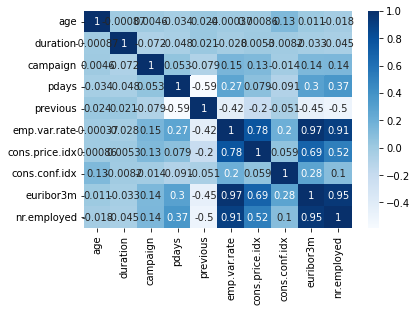

In [12]:
# Correlations
#correlations = df.corr()  # this is a dataframe
# let's see how much each attribute correlates with the outcome 'like'
#correlations['y'].sort_values(ascending=False)

sns.heatmap(df[features].corr(), cmap='Blues', annot=True)
#sns.heatmap()

# --------------------------------------------------------------------------------------------------------------------------------------------
# Preprocessing

In [13]:
# use Label Encoder to convert label into numbers

df[label] = df[label].apply(LabelEncoder().fit_transform)
df = df.apply(LabelEncoder().fit_transform)
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,39,3,1,0,0,0,0,1,6,1,261,0,26,0,1,8,18,16,287,8,0
1,40,7,1,3,1,0,0,1,6,1,149,0,26,0,1,8,18,16,287,8,0
2,20,7,1,3,0,2,0,1,6,1,226,0,26,0,1,8,18,16,287,8,0
3,23,0,1,1,0,0,0,1,6,1,151,0,26,0,1,8,18,16,287,8,0
4,39,7,1,3,0,0,2,1,6,1,307,0,26,0,1,8,18,16,287,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,56,5,1,5,0,2,0,0,7,0,334,0,26,0,1,5,25,0,171,0,1
41184,29,1,1,5,0,0,0,0,7,0,383,0,26,0,1,5,25,0,171,0,0
41185,39,5,1,6,0,2,0,0,7,0,189,1,26,0,1,5,25,0,171,0,0
41186,27,9,1,5,0,0,0,0,7,0,442,0,26,0,1,5,25,0,171,0,1


In [14]:
# convert categorical values into dummy/indicator variables
df_dummies = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan',
           'contact', 'month', 'day_of_week', 'poutcome'])
df_dummies.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_0,job_1,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,job_11,marital_0,marital_1,marital_2,marital_3,education_0,education_1,education_2,education_3,education_4,education_5,education_6,education_7,default_0,default_1,default_2,housing_0,housing_1,housing_2,loan_0,loan_1,loan_2,contact_0,contact_1,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,poutcome_0,poutcome_1,poutcome_2
0,39,261,0,26,0,8,18,16,287,8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,40,149,0,26,0,8,18,16,287,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,20,226,0,26,0,8,18,16,287,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,23,151,0,26,0,8,18,16,287,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,39,307,0,26,0,8,18,16,287,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [15]:
df = df_dummies

In [16]:
# look at the new columns
df_dummies.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_0', 'job_1', 'job_2', 'job_3', 'job_4', 'job_5', 'job_6', 'job_7',
       'job_8', 'job_9', 'job_10', 'job_11', 'marital_0', 'marital_1',
       'marital_2', 'marital_3', 'education_0', 'education_1', 'education_2',
       'education_3', 'education_4', 'education_5', 'education_6',
       'education_7', 'default_0', 'default_1', 'default_2', 'housing_0',
       'housing_1', 'housing_2', 'loan_0', 'loan_1', 'loan_2', 'contact_0',
       'contact_1', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'poutcome_0', 'poutcome_1', 'poutcome_2'],
      dtype='object')

In [17]:
# no need for dropna since df has no missing values
df_dummies = df_dummies.dropna()

In [18]:
#df = df.drop(['duration'], axis=1)
df_dummies = df_dummies.drop(['duration'], axis=1)

In [19]:
df_dummies.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_0', 'job_1', 'job_2', 'job_3', 'job_4', 'job_5', 'job_6', 'job_7',
       'job_8', 'job_9', 'job_10', 'job_11', 'marital_0', 'marital_1',
       'marital_2', 'marital_3', 'education_0', 'education_1', 'education_2',
       'education_3', 'education_4', 'education_5', 'education_6',
       'education_7', 'default_0', 'default_1', 'default_2', 'housing_0',
       'housing_1', 'housing_2', 'loan_0', 'loan_1', 'loan_2', 'contact_0',
       'contact_1', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'poutcome_0', 'poutcome_1', 'poutcome_2'],
      dtype='object')

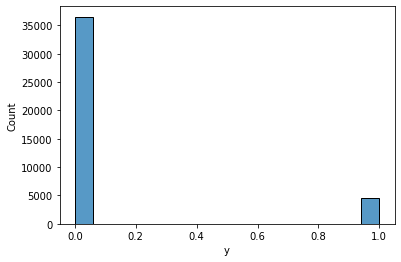

In [20]:
# plot histogram of the label and calculate the imbalance in the dataset
sns.histplot(data=df_dummies, x='y')

In [21]:
df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [22]:
imbalance = df['y'].value_counts()[0]/df['y'].value_counts()[1]
print("The calculated imbalance is", imbalance)

The calculated imbalance is 7.876724137931035


# --------------------------------------------------------------------------------------------------------------------------------------
# Model the Data

Using the train_test_split function in scikit-learn, separate your dataset into a training
and a test set, with a test size of 20% and random_state=50. Make sure the train/test 
split is stratified (and check that it is!). 

Stratified means that the percentages of classes in each fold remains constant.

In [23]:
df_dummies

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_0,job_1,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,job_11,marital_0,marital_1,marital_2,marital_3,education_0,education_1,education_2,education_3,education_4,education_5,education_6,education_7,default_0,default_1,default_2,housing_0,housing_1,housing_2,loan_0,loan_1,loan_2,contact_0,contact_1,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,poutcome_0,poutcome_1,poutcome_2
0,39,0,26,0,8,18,16,287,8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,40,0,26,0,8,18,16,287,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,20,0,26,0,8,18,16,287,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,23,0,26,0,8,18,16,287,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,39,0,26,0,8,18,16,287,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,56,0,26,0,5,25,0,171,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41184,29,0,26,0,5,25,0,171,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41185,39,1,26,0,5,25,0,171,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41186,27,0,26,0,5,25,0,171,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


In [24]:
features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_0', 'job_1', 'job_2', 'job_3', 'job_4', 'job_5', 'job_6', 'job_7',
       'job_8', 'job_9', 'job_10', 'job_11', 'marital_0', 'marital_1',
       'marital_2', 'marital_3', 'education_0', 'education_1', 'education_2',
       'education_3', 'education_4', 'education_5', 'education_6',
       'education_7', 'default_0', 'default_1', 'default_2', 'housing_0',
       'housing_1', 'housing_2', 'loan_0', 'loan_1', 'loan_2', 'contact_0',
       'contact_1', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'poutcome_0', 'poutcome_1', 'poutcome_2']

In [25]:
#X1 = df[features].copy()
#y1 = df['y'].copy()

X = df_dummies[features].copy()
y = df_dummies['y'].copy()

In [26]:
# we can use Standard Scaler to scale some numerical columns
numerical_features = ['duration', 'pdays']

# Use column transformer: numerical features will be standardised;
# We can use a ColumnTransformer to transform only some types of columns in different ways
colTransformer = ColumnTransformer([
    ('num', StandardScaler(), numerical_features)],
    remainder='passthrough'  # i.e., leave the rest of the columns untouched -- otherwise, they're dropped
    )

X = colTransformer.fit_transform(df)
X.shape

(41188, 64)

In [27]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, 
                                                     random_state=50, stratify=y)

Report the results of 10-fold stratified cross-validation on the training set using a random forest classifier with 100 trees and depth=3.

Ensure you're using an appropriate metric (print sorted(sklearn.metrics.SCORERS.keys()) to see what are the valid options and choose one for cross-validation).

In [43]:
# look at the dummy classifier
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
scores = cross_val_score(dummy_clf, X_train, y_train, cv=10, scoring=make_scorer(acc))
print("Dummy ACC: %.2f" % acc(y, dummy_clf.predict(X)))

Dummy ACC: 0.80


In [29]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=3) # number of trees and max depth
scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring=make_scorer(acc))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.94 +/- 0.01


In [30]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [40]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=3) # number of trees and max depth
rfc_scores = cross_val_score(rfc, X, y, cv=10, scoring='f1')  # cross-validation
print("F1: %.2f +/- %.2f" % (rfc_scores.mean(), rfc_scores.std()))

F1: 0.37 +/- 0.32


In [41]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
dummy_scores = cross_val_score(dummy_clf, X_train, y_train, cv=10, scoring='f1')
print("Dummy F1: %.2f" % acc(y, dummy_clf.predict(X)))
print('Dummy F1 Score: %.2f +/- %.2f'% (dummy_scores.mean(), dummy_scores.std()))

Dummy F1: 0.80
Dummy F1 Score: 0.11 +/- 0.01


# Use GridSearchCV to find a better set of parameters for your random forest.

In [33]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
 
# train the model on train set without using GridSearchCV 
model = SVC() 
model.fit(X_train, y_train) 
   
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7310
           1       0.60      0.10      0.17       928

    accuracy                           0.89      8238
   macro avg       0.75      0.54      0.56      8238
weighted avg       0.86      0.89      0.85      8238



In [34]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['linear']}  
   
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(X_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions)) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7310
           1       1.00      1.00      1.00       928

    accuracy                           1.00      8238
   macro avg       1.00      1.00      1.00      8238
weighted avg       1.00      1.00      1.00      8238



In [35]:
sklearn.metrics.f1_score(y, y_pred_dummy)

NameError: ignored